In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
client = pd.read_csv("data/train/client_train.csv", low_memory=False, parse_dates=['creation_date'])
invoice = pd.read_csv("data/train/invoice_train.csv", low_memory=False, parse_dates=['invoice_date'])

/var/folders/vv/4d0yjm893_xcqs8y21lfl70c0000gn/T/ipykernel_2213/1681245387.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  client = pd.read_csv("data/train/client_train.csv", low_memory=False, parse_dates=['creation_date'])


### Column info

##### Invoice data

* consommation_level = consumption of electricity or gas (kwh/m^3). Each consumption level has a threshold, after which someone moves to the next level.
* old index/new index = the measurment of electricity or gas at a given time.
* months_number = number of months between each measurement
* counter_coeffiecient = is an additionnal coefficient to be added when standard consumpution is exceeded / Indicates the power consumption
* reading_remarque = Reading remarque is notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
* counter_statue = status of the counter (works/does not work /on hold et.c)
* tarif_type = information regarding how much tax you pay.
* counter_type = the type of consumption (Electricity or gas)
* counter_code = ???

##### Client data

* creation_date = When the contract enacted
* client_catg = the type of contract that a client has
* target = whether the client is stealing from the company(1) or not (0)

In [3]:
invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [4]:
client.groupby("target")['client_id'].count()*100/client.shape[0]

target
0.0    94.415948
1.0     5.584052
Name: client_id, dtype: float64

In [5]:
invoice.isna().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [6]:
invoice.counter_code.value_counts()

counter_code
203    1516836
5      1352035
207     555628
413     378917
202     343251
420      98273
410      69080
433      34447
10       27744
442      17050
25       14934
407      13768
204      12427
453       8290
201       7672
467       7302
506       3389
483       2830
214       2643
40        2482
532       1982
565       1082
403       1070
450       1059
600        807
210        789
102        313
227        178
65          74
101         74
16          73
310         51
307         50
305         44
222         42
0           33
317         16
303          5
333          4
367          3
325          1
1            1
Name: count, dtype: int64

In [7]:
invoice = invoice.drop('counter_number', axis = 1)


In [8]:
invoice = invoice.drop('counter_code', axis = 1)

In [9]:
invoice['total_cons'] = invoice['consommation_level_1'] + invoice['consommation_level_2']+ invoice['consommation_level_3'] + invoice['consommation_level_4']
invoice['index_cons'] = invoice['new_index']-invoice['old_index']

In [10]:
100*((invoice['total_cons'] == invoice['index_cons']).sum())/invoice.shape[0]

99.5770368184591

In [11]:
df = pd.merge(client, invoice, on='client_id', how='left')

In [12]:
df['day'] = df['invoice_date'].dt.day
df['month'] = df['invoice_date'].dt.month
df['year'] = df['invoice_date'].dt.year
df['start_year'] = df['creation_date'].dt.year

In [13]:
df = df.drop(['invoice_date', 'creation_date'], axis = 1)

#### Effect of counter coefficient
Almost all values are under 1, no disproportionallity with respect to target

In [14]:
df.counter_coefficient.value_counts()/df.shape[0]

counter_coefficient
1     9.996321e-01
2     1.979115e-04
3     7.170382e-05
40    4.400515e-05
30    3.060256e-05
0     1.027531e-05
6     6.701291e-06
4     2.680517e-06
10    1.340258e-06
20    6.701291e-07
9     6.701291e-07
50    4.467528e-07
33    2.233764e-07
5     2.233764e-07
11    2.233764e-07
8     2.233764e-07
Name: count, dtype: float64

<Axes: xlabel='counter_coefficient', ylabel='count'>

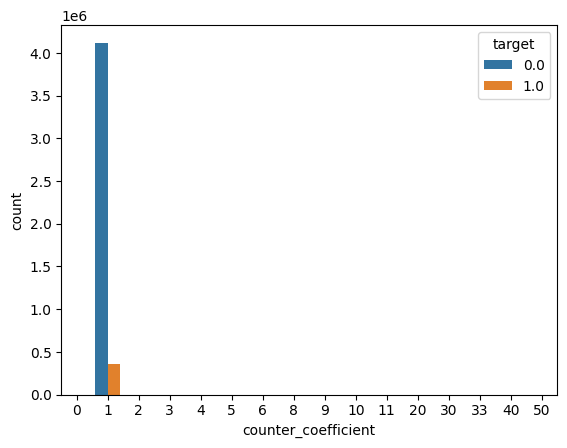

In [17]:
sns.countplot(df, x = 'counter_coefficient', hue = 'target') #, stat= 'percent')

#### Effect of incocistent data between total consumption and index values

In [18]:
inc = df[df['total_cons'] != df['index_cons']]

In [19]:
inc.groupby(['target'])['region'].count()*100/inc.shape[0]

target
0.0    92.030631
1.0     7.969369
Name: region, dtype: float64

<Axes: xlabel='target', ylabel='count'>

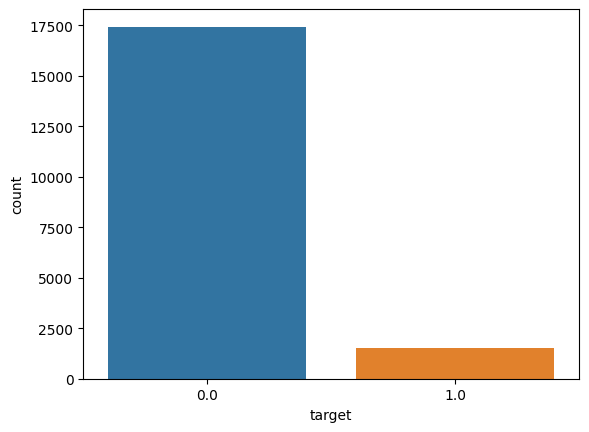

In [21]:
sns.countplot(inc, x = 'target') #, stat= 'percent')

#### Effect of measurement increment on fraud

In [22]:
bins = [0, 4, 12, 636624]
labels = ['quarter', 'year', 'lt_year']
df['months_bins'] = pd.cut(df['months_number'], bins=bins, labels=labels)

<Axes: xlabel='months_bins', ylabel='count'>

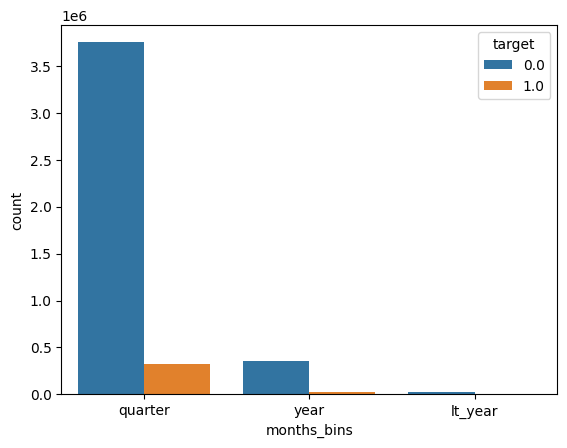

In [24]:
sns.countplot(df, x = 'months_bins', hue= 'target', orient = 'v')

In [25]:
df.groupby(['months_bins', "target"])['client_id'].count()*100/df.shape[0]

months_bins  target
quarter      0.0       83.746978
             1.0        7.210523
year         0.0        7.867741
             1.0        0.637695
lt_year      0.0        0.497549
             1.0        0.039471
Name: client_id, dtype: float64

In [26]:


df.groupby(['months_bins', "region"])['client_id'].count()*100/df.shape[0]

months_bins  region
quarter      101       21.441162
             103        5.983762
             104        7.971186
             105        1.025990
             106        0.469269
                         ...    
lt_year      313        0.004892
             371        0.016686
             372        0.002412
             379        0.000759
             399        0.000246
Name: client_id, Length: 75, dtype: float64

#### Effect of region on fraudulent numbers
The regions 101, 103,104, 107 and 311 have disproportional amount of fraudulent clients

<Axes: xlabel='count', ylabel='region'>

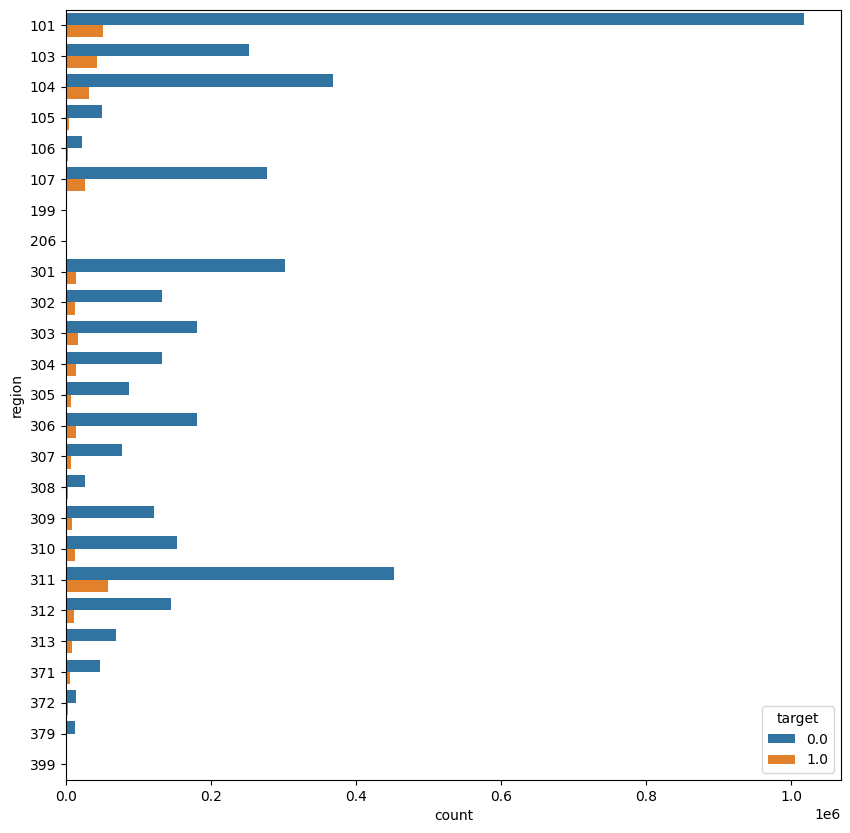

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.countplot(df, y= 'region', hue = 'target', orient = 'h', ax= ax)

### Effect of consumption spread on fraud

In [28]:
df['cons_per_month'] = df['total_cons']/df['months_number']

In [29]:

df_min_max = df[df['counter_type'] == 'ELEC'].groupby(['client_id'])['cons_per_month'].agg(['max', 'min']).reset_index().copy(deep=True)

In [30]:
df_min_max['spread'] = df_min_max['max'] - df_min_max['min']

##### 4 % of the clients have less than 5 kWh consumption per month.

In [31]:
df_min_max[df_min_max['max']<5].shape[0]*100/df_min_max.shape[0]

4.099692170752513

In [32]:
df_min_max =pd.merge(df_min_max, client[['client_id', 'target','region']], on = 'client_id', how = 'left')

##### Only 0.02 % of the client have a consumption of less than 5 kWh and are fraudulent which is disproportiinate to the overall fraudulent

In [33]:
df_min_max[df_min_max['max']<5].groupby(['target'])['client_id'].count()*100/df_min_max.shape[0]

target
0.0    4.072989
1.0    0.026703
Name: client_id, dtype: float64

In [34]:
df.groupby(['counter_type', 'target'])['client_id'].count()*100/df.shape[0]

counter_type  target
ELEC          0.0       63.507201
              1.0        5.279456
GAZ           0.0       28.605111
              1.0        2.608232
Name: client_id, dtype: float64

In [35]:
df_min_max.describe()

,max,min,spread,target,region
count,134815.000000,134815.000000,134815.000000,134815.000000,134815.000000
mean,511.182450,50.369903,460.812547,0.056077,206.556778
std,2518.105283,291.508364,2463.259778,0.230071,104.208851
min,0.000000,0.000000,0.000000,0.000000,101.000000
25%,141.750000,0.000000,106.500000,0.000000,103.000000
50%,251.500000,6.500000,214.500000,0.000000,206.000000
75%,438.500000,54.000000,394.854167,0.000000,307.000000
max,499836.500000,47880.000000,499836.500000,1.000000,399.000000


In [36]:
bins = [-1, 100, 200, 400, 1000, 500_000]
labels = ['100', '200', '400', '1000', 'gt_1000']
df_min_max['spread_bins'] = pd.cut(df_min_max['spread'], bins=bins, labels=labels)

In [37]:
bins = [-1, 100, 200, 400, 1000, 500_000]
labels = ['100', '200', '400', '1000', 'gt_1000']
df_min_max['max_bins'] = pd.cut(df_min_max['max'], bins=bins, labels=labels)

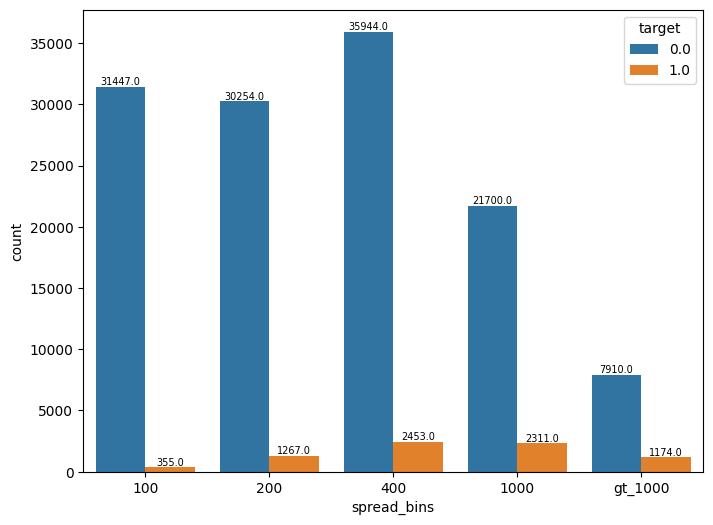

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(df_min_max, x = 'spread_bins', hue= 'target', orient = 'v', )
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), str(round(p.get_height(),2)), 
            ha="center", va="bottom", size=7)
    
plt.show()

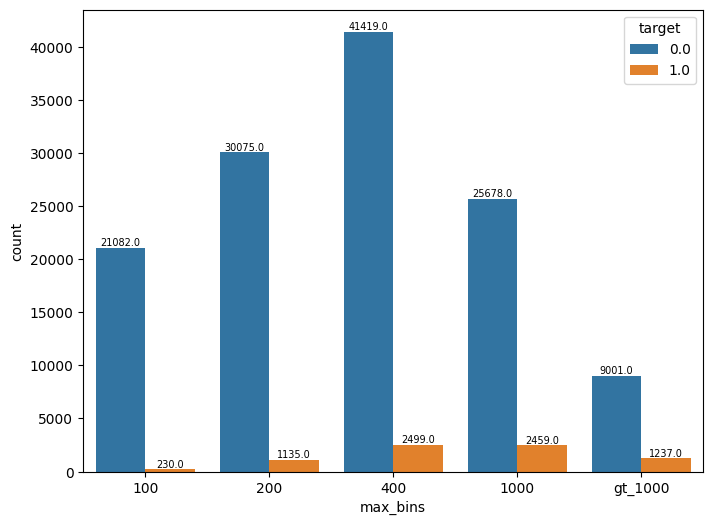

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(df_min_max, x = 'max_bins', hue= 'target', orient = 'v', )
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), str(round(p.get_height(),2)), 
            ha="center", va="bottom", size=7)
    
plt.show()

#### The clients with monthly spread consumption lower than 100 are less likely to be fraudulent

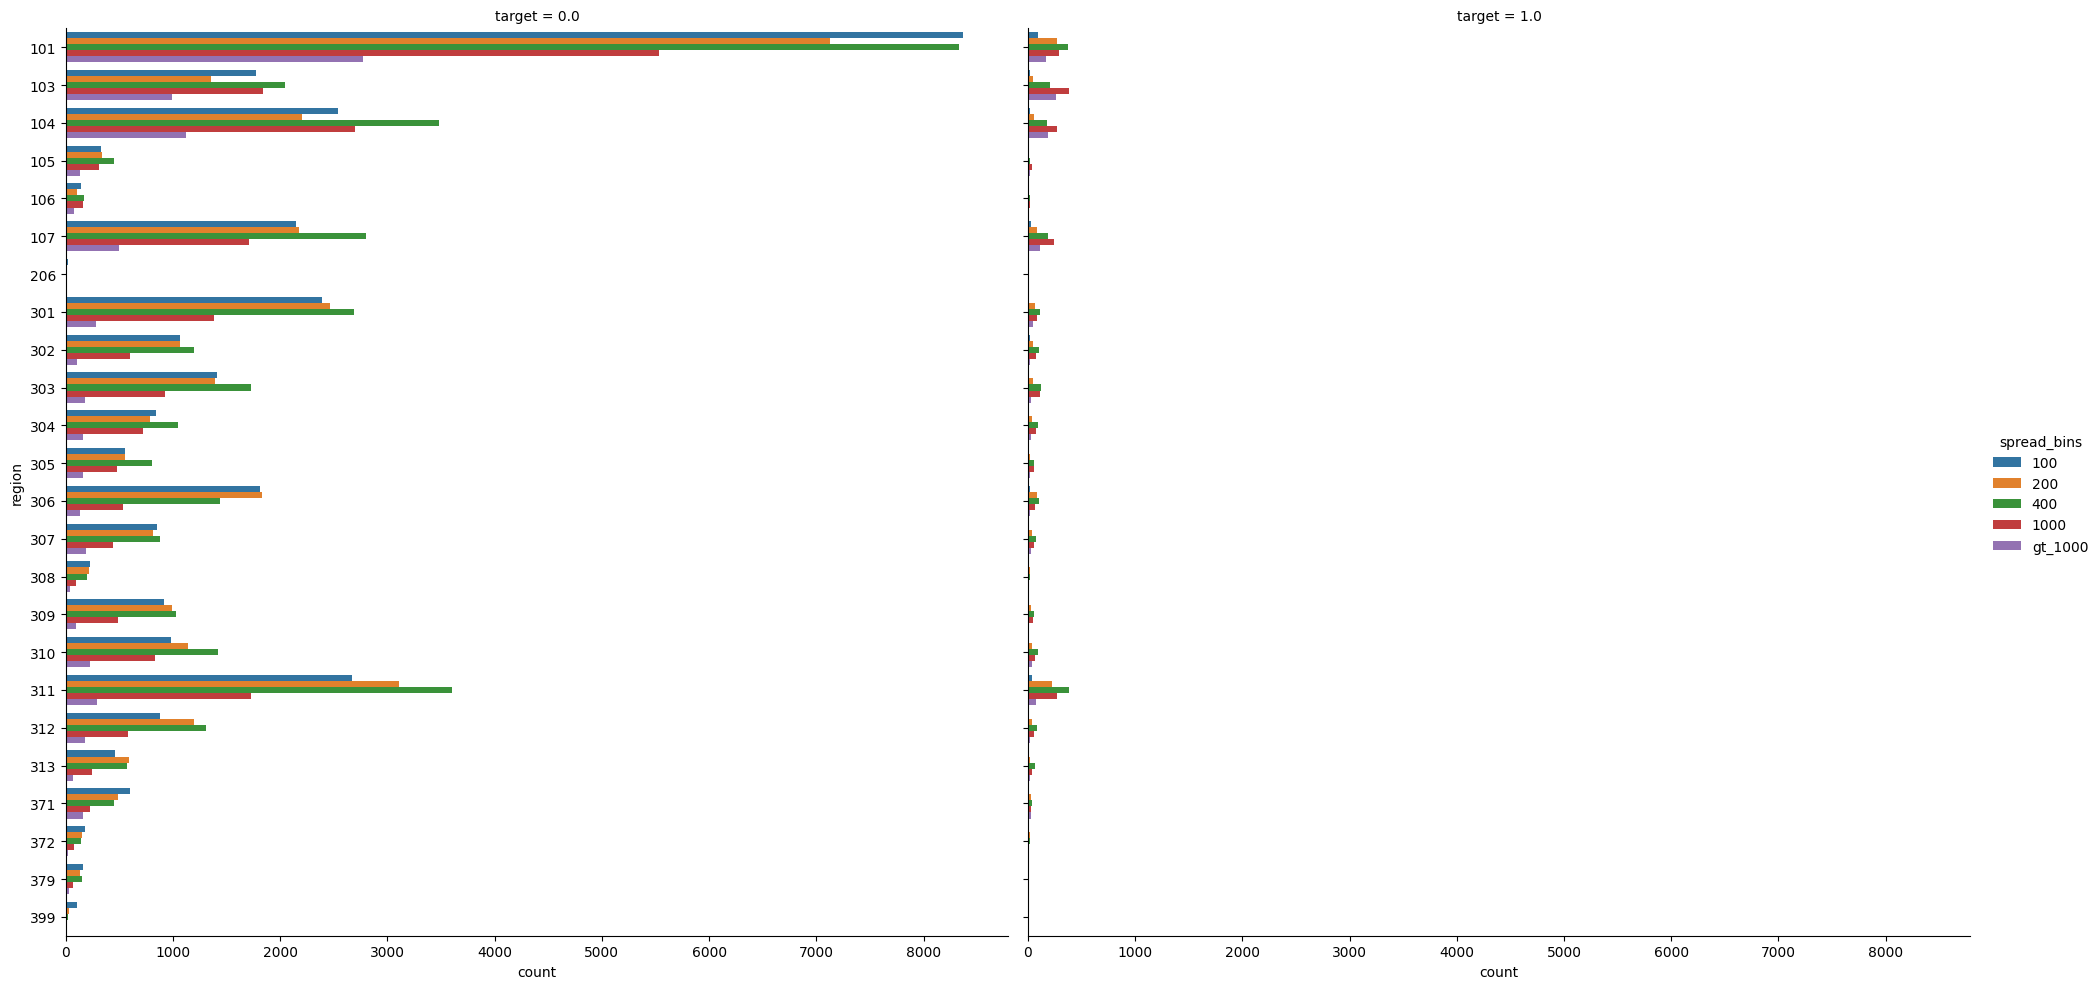

In [41]:

sns.catplot(df_min_max, y = 'region', hue= 'spread_bins', kind = 'count', orient = 'h', col = 'target', height= 10, aspect= 1.0)

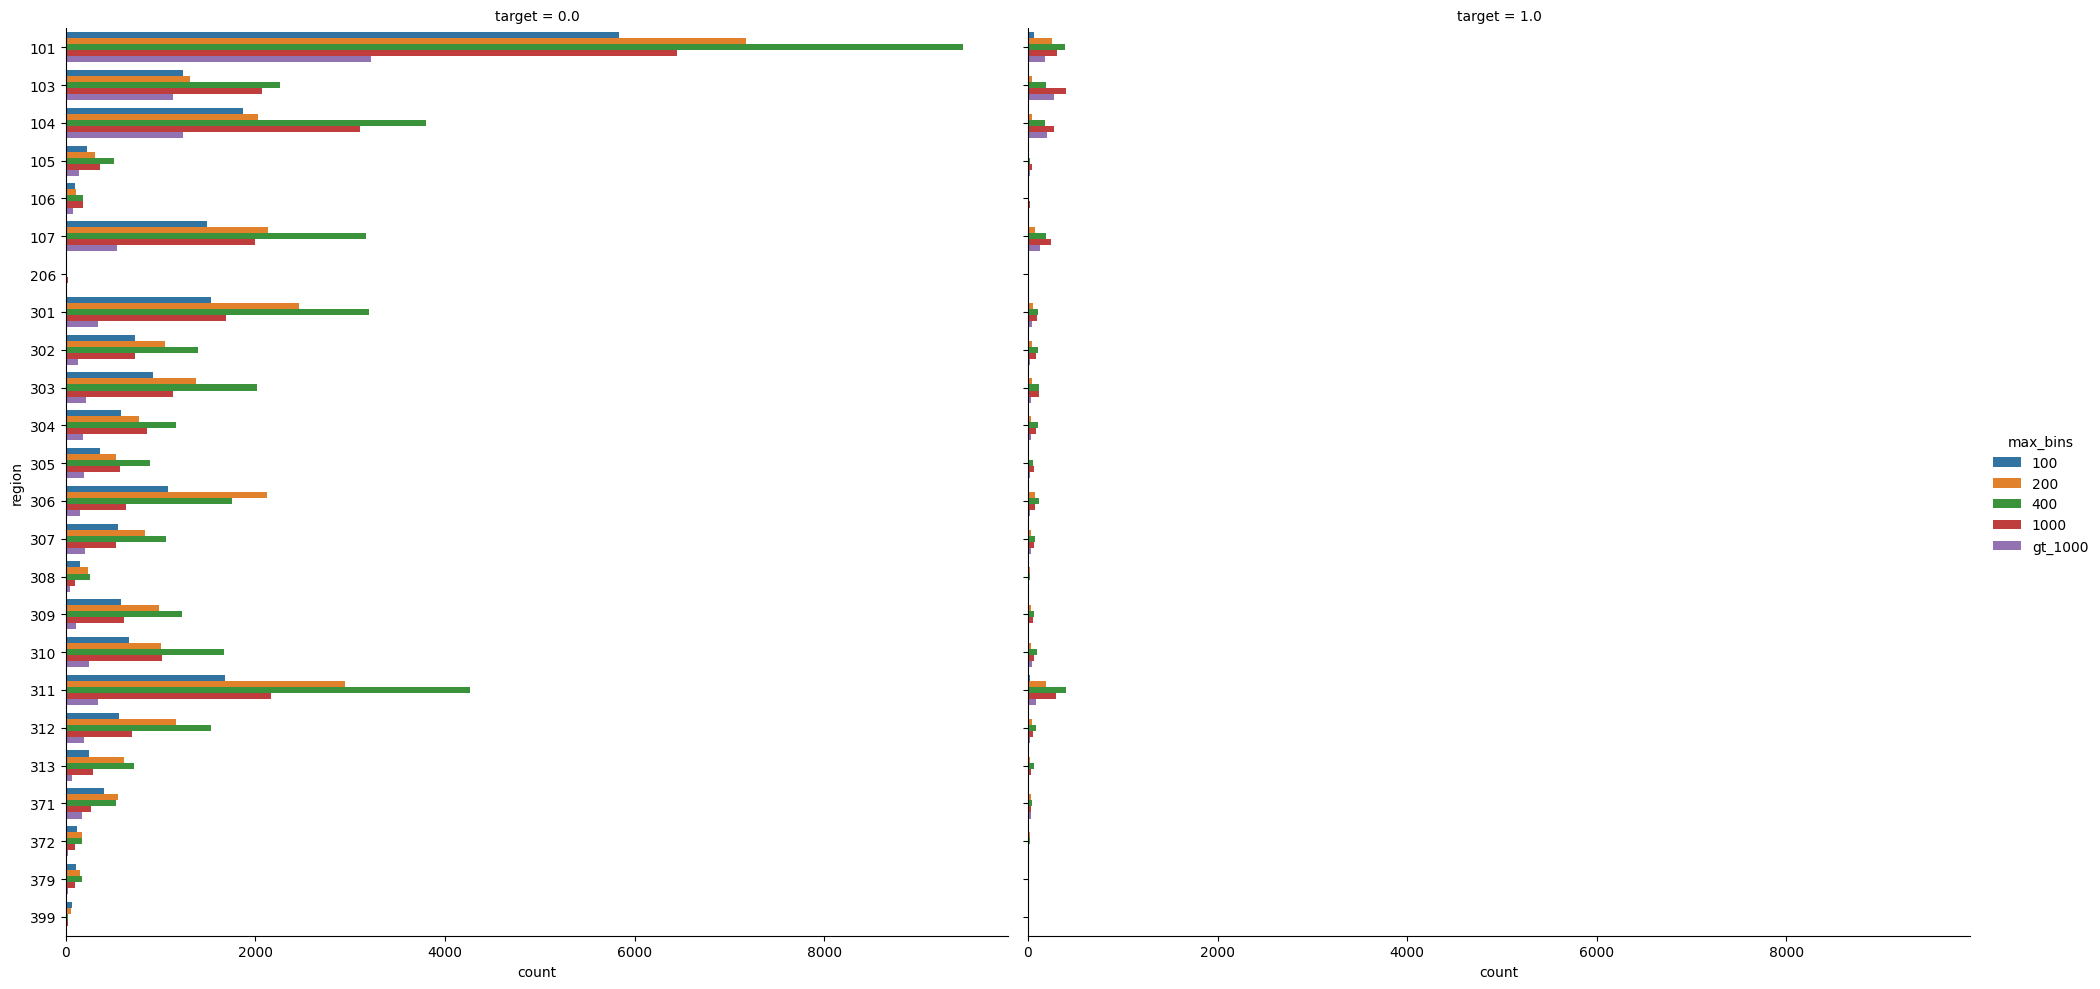

In [42]:
sns.catplot(df_min_max, y = 'region', hue= 'max_bins', kind = 'count', orient = 'h', col = 'target', height= 10, aspect= 1.0)

### Effect of total consumption on fraud

In [43]:
df['total_cons'].describe()

count    4.476749e+06
mean     5.935341e+02
std      1.775228e+03
min      0.000000e+00
25%      8.000000e+01
50%      3.090000e+02
75%      6.570000e+02
max      9.999100e+05
Name: total_cons, dtype: float64

In [44]:
bins = [-1, 100, 500, 1000, 10_000]
labels = ['100', '500', '1000', '10k']
df['cons_bins'] = pd.cut(df['total_cons'], bins=bins, labels=labels)

TypeError: Axes.boxplot() got an unexpected keyword argument 'log_scale'

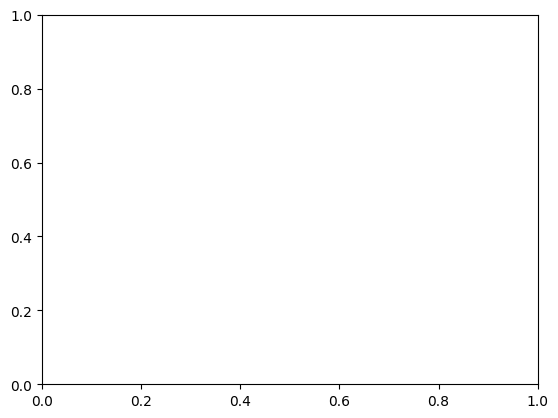

In [46]:
sns.boxplot(df, y= 'total_cons', log_scale=True)

<Axes: xlabel='cons_bins', ylabel='count'>

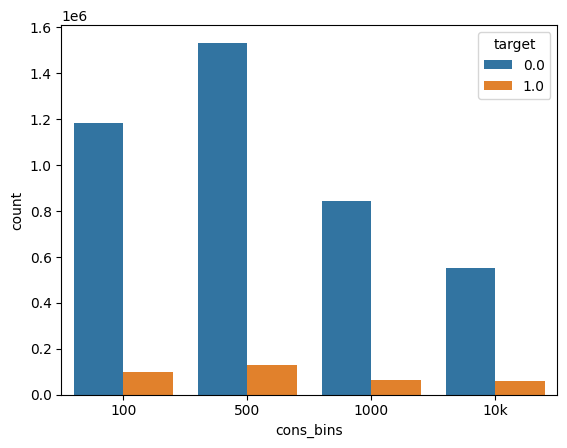

In [48]:
sns.countplot(df, x = 'cons_bins', hue= 'target', orient = 'v')

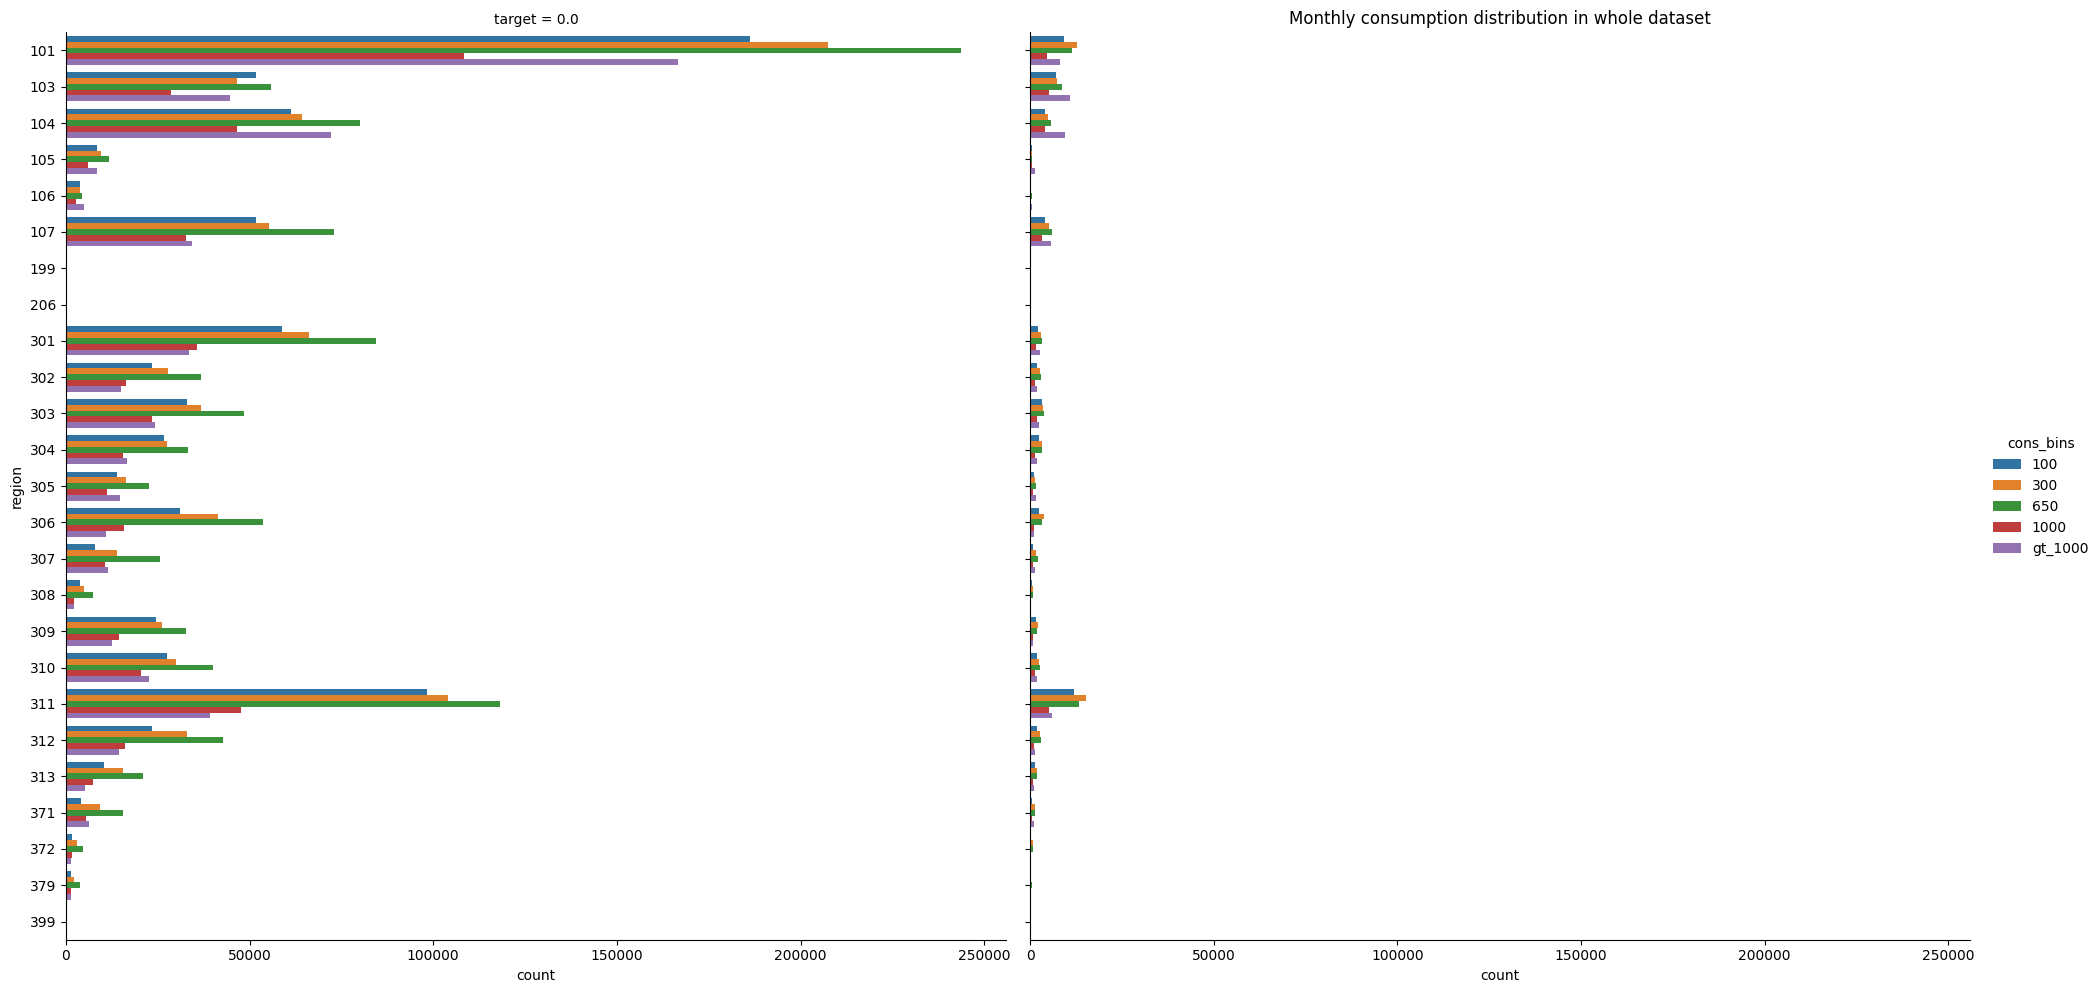

In [ ]:
sns.catplot(df, y = 'region', hue= 'cons_bins', kind = 'count', orient = 'h', col = 'target', height= 10, aspect= 1.0)
plt.title('Monthly consumption distribution in whole dataset')
plt.show()

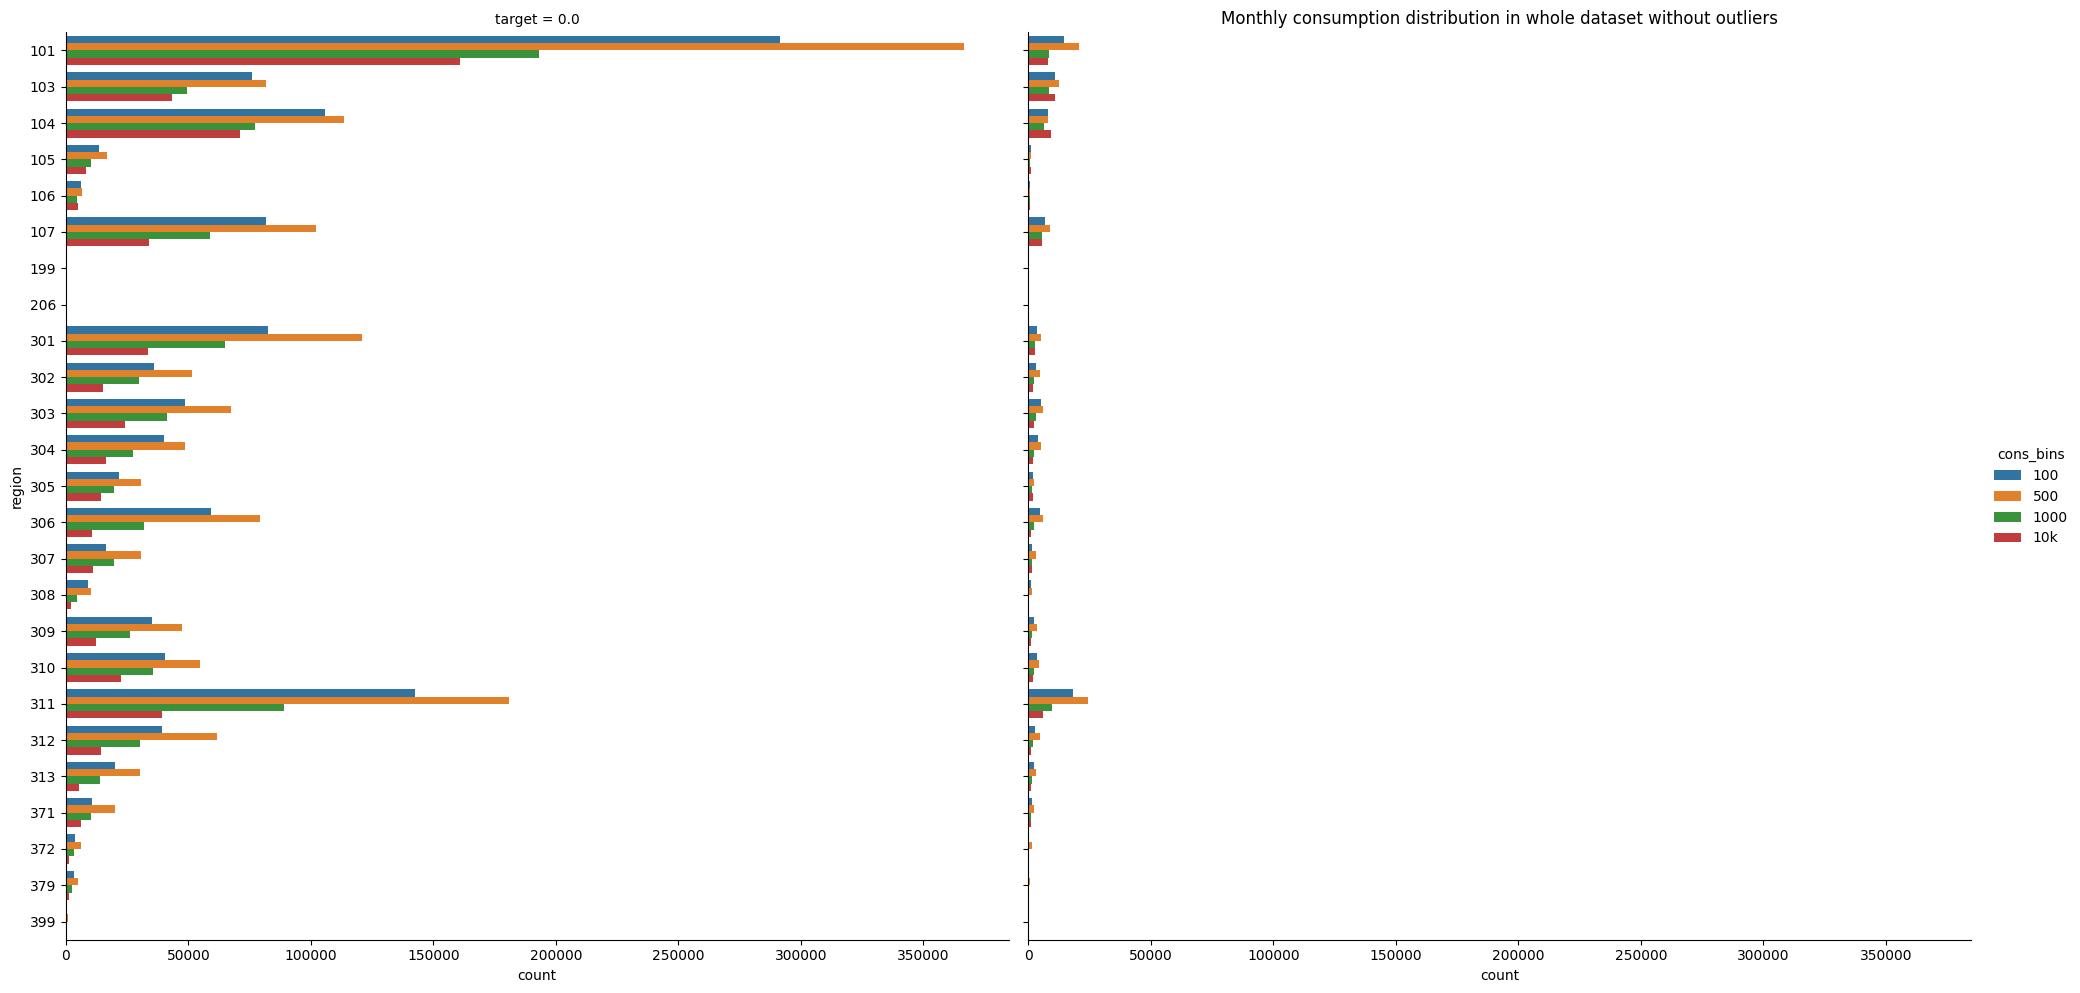

In [ ]:
sns.catplot(df, y = 'region', hue= 'cons_bins', kind = 'count', orient = 'h', col = 'target', height= 10, aspect= 1.0)
plt.title('Monthly consumption distribution in whole dataset without outliers')
plt.show()

In [ ]:
df_std = df[df['counter_type'] == 'ELEC'].groupby(['client_id'])['cons_per_month'].agg(['max', 'min']).reset_index()

#### Baseline model

In [49]:
df_min_max['pred'] = 0

In [50]:
df_min_max.loc[(df_min_max["region"].isin([101,103,104,107,311])) & (df_min_max["max"]>100), 'pred'] = 1

In [51]:
df_min_max

,client_id,max,min,spread,target,region,spread_bins,max_bins,pred
0,train_Client_0,346.500000,19.00,327.500000,0.0,101,400,400,1
1,train_Client_1,194.000000,81.50,112.500000,0.0,107,200,200,1
2,train_Client_10,256.833333,47.00,209.833333,0.0,301,400,400,0
3,train_Client_100,3.750000,0.00,3.750000,0.0,105,100,100,0
4,train_Client_1000,595.500000,62.00,533.500000,0.0,303,1000,1000,0
...,...,...,...,...,...,...,...,...,...
134810,train_Client_99995,0.000000,0.00,0.000000,0.0,304,100,100,0
134811,train_Client_99996,207.750000,0.75,207.000000,0.0,311,400,400,1
134812,train_Client_99997,144.500000,70.00,74.500000,0.0,311,100,200,1
134813,train_Client_99998,66.875000,51.50,15.375000,0.0,101,100,100,0


In [52]:
y_real= df_min_max['target']
y_pred = df_min_max['pred']

Accuracy : 0.53
Balanced Accuracy : 0.55
F1 Score : 0.12
Recall:  0.58
Precision:  0.07
AUC Score:  0.55


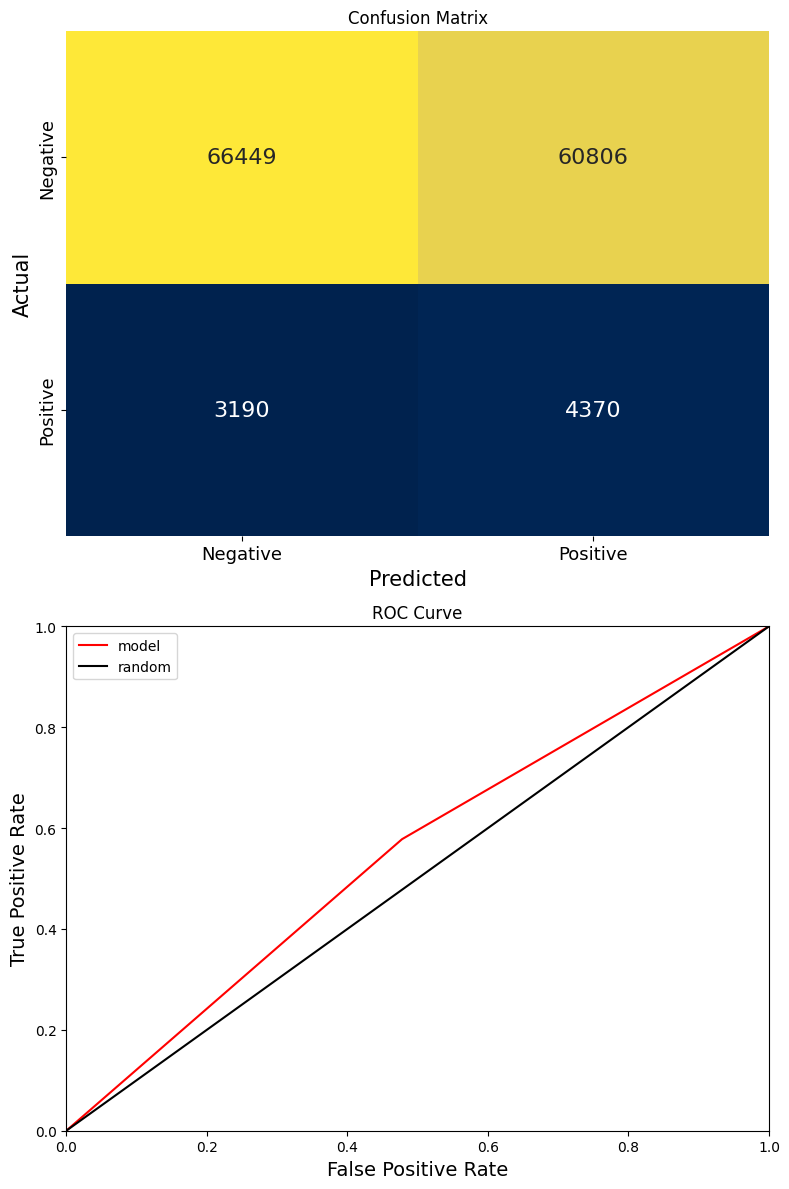

In [53]:
from utils import eval

eval(y_pred, y_real)

### Investigation of deviation of total consumption per year

In [54]:
df_int= df[df['counter_type'] == 'ELEC'].groupby(['client_id', 'year'])['total_cons'].sum().reset_index()

In [55]:
df_int

,client_id,year,total_cons
0,train_Client_0,2005,124
1,train_Client_0,2006,462
2,train_Client_0,2007,698
3,train_Client_0,2008,622
4,train_Client_0,2009,894
...,...,...,...
1210521,train_Client_99997,2017,1208
1210522,train_Client_99997,2018,902
1210523,train_Client_99997,2019,1653
1210524,train_Client_99998,2005,741


In [56]:
df_std = df_int.groupby(['client_id'])['total_cons'].std().reset_index().dropna()

In [57]:
df_std =pd.merge(df_std, client[['client_id', 'target','region']], on = 'client_id', how = 'left')

In [58]:
df_std.rename({'total_cons': 'yearly_cons_std'}, axis=1, inplace=True)

In [59]:
df_std

,client_id,yearly_cons_std,target,region
0,train_Client_0,738.628214,0.0,101
1,train_Client_1,359.808375,0.0,107
2,train_Client_10,755.152498,0.0,301
3,train_Client_100,5.398412,0.0,105
4,train_Client_1000,1411.344324,0.0,303
...,...,...,...,...
124108,train_Client_99993,1025.788781,0.0,101
124109,train_Client_99994,12.741010,0.0,101
124110,train_Client_99995,0.000000,0.0,304
124111,train_Client_99996,539.784437,0.0,311


In [60]:
bins = [-1, 350, 650, 1000, 10_000]
labels = ['350', '650', '1000', '10000']
df_std['std_bins'] = pd.cut(df_std['yearly_cons_std'], bins=bins, labels=labels)

In [61]:
df_std[df_std['yearly_cons_std'] > 10000].groupby("target").count()

,client_id,yearly_cons_std,region,std_bins
target,,,,
0.0,1173,1173,1173,0
1.0,168,168,168,0


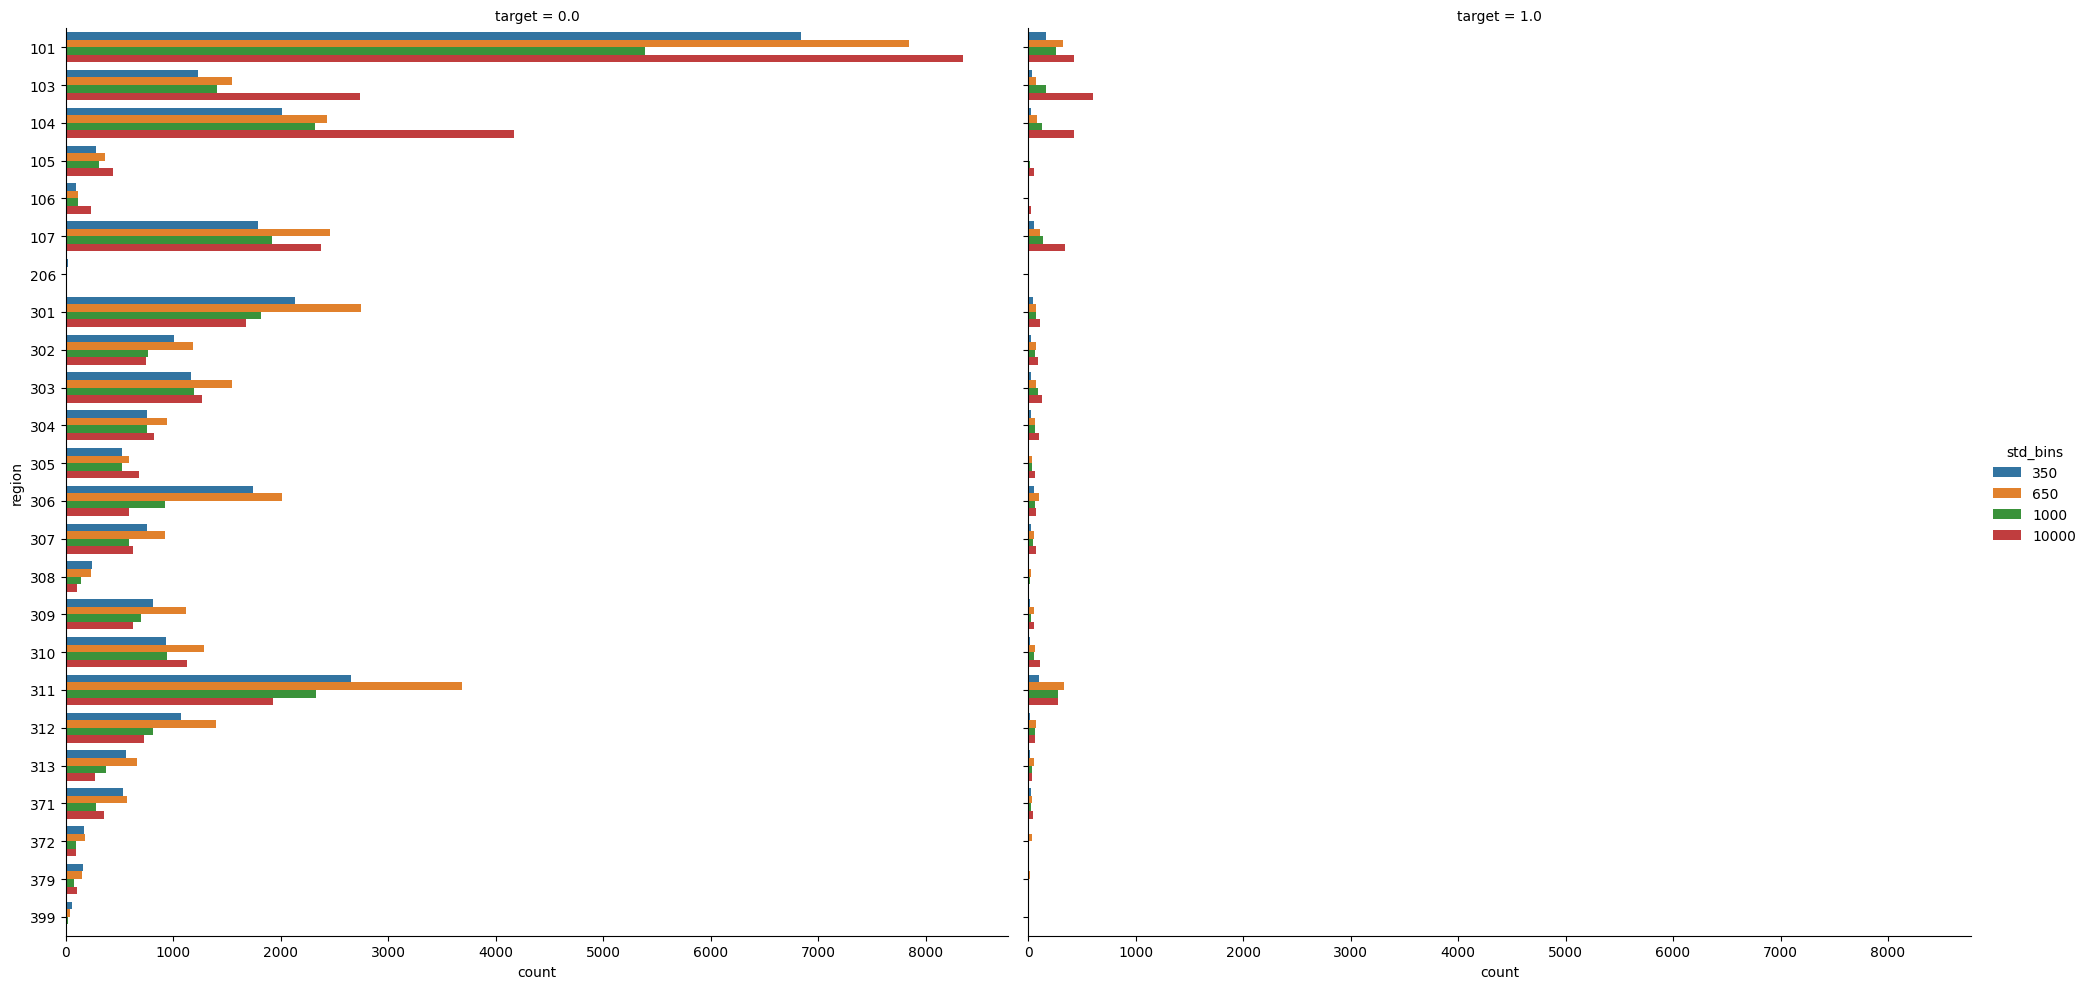

In [ ]:
sns.catplot(df_std, y = 'region', hue= 'std_bins', kind = 'count', orient = 'h', col = 'target', height= 10, aspect= 1.0)

##### It appears to be a disproportionate amount of clients that commit fraud with a standard deviation above 10k on the yearly consumption 

#### Effect of spread of yearly consumption on fraud

In [62]:
df_y_spread = df_int.groupby(['client_id'])['total_cons'].agg(['min', 'max']).reset_index().dropna()

In [63]:
df_y_spread['y_spread'] = df_y_spread['max'] - df_y_spread['min']

TypeError: Axes.boxplot() got an unexpected keyword argument 'log_scale'

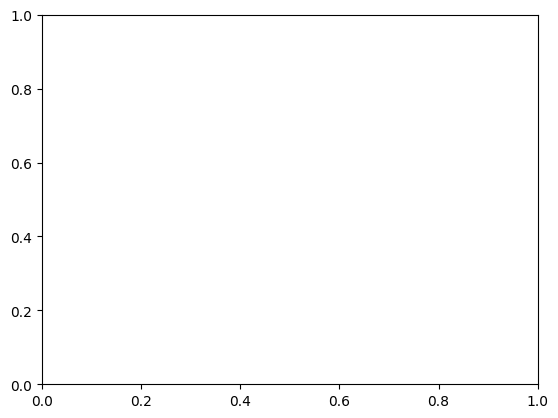

In [64]:
sns.boxplot(df_y_spread, y = 'y_spread', log_scale= True)

In [ ]:
df_y_spread.describe()

,min,max,y_spread
count,134815.000000,134815.000000,134815.000000
mean,623.522553,3668.114297,3044.591744
std,3119.511202,9935.879032,8806.292010
min,0.000000,0.000000,0.000000
25%,20.000000,1213.000000,814.000000
50%,254.000000,2159.000000,1740.000000
75%,601.000000,3607.000000,3077.000000
max,581782.000000,999673.000000,991932.000000


In [65]:
df_y_spread =pd.merge(df_y_spread, client[['client_id', 'target','region']], on = 'client_id', how = 'left')

In [66]:
bins = [100, 800, 1500, 3000, 30_000]
labels = ['800', '1500', '3000', '30k']
df_y_spread['spread_bins'] = pd.cut(df_y_spread['y_spread'], bins=bins, labels=labels)

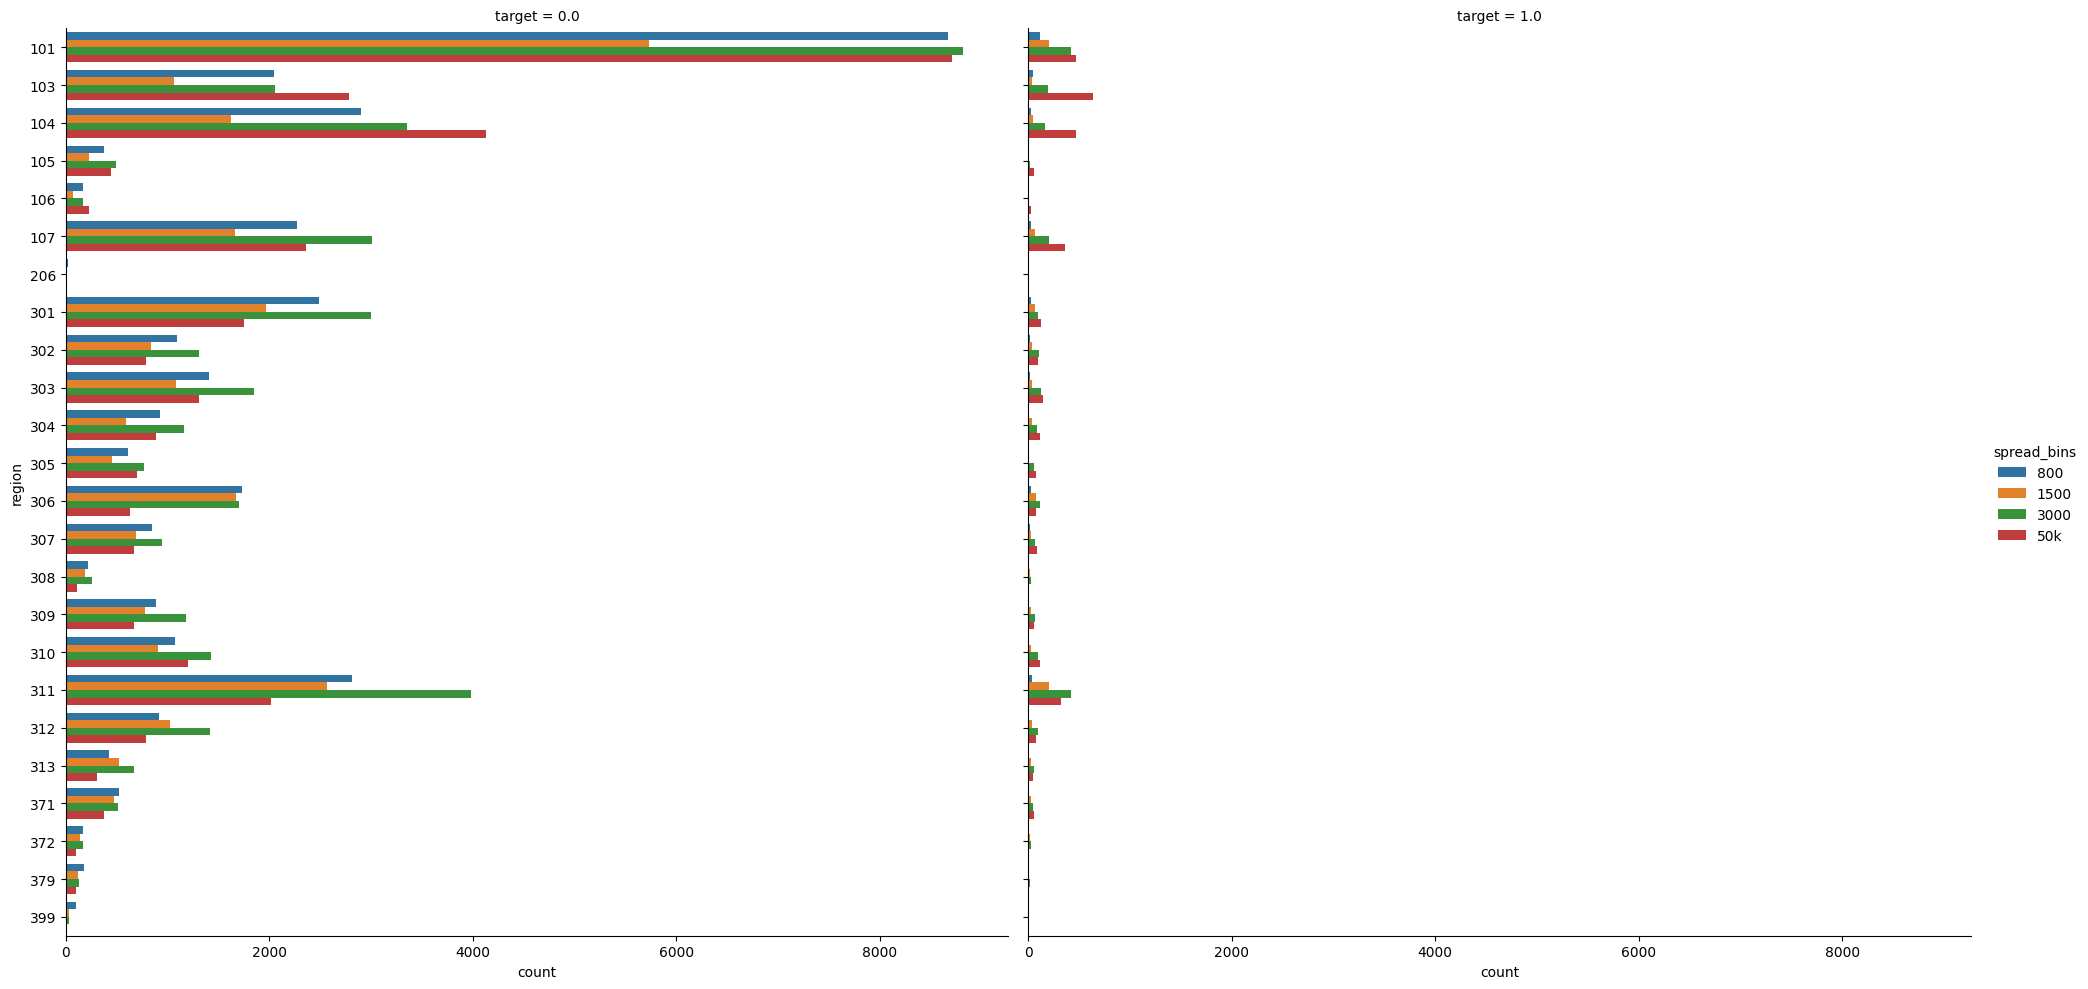

In [ ]:
sns.catplot(df_y_spread, y = 'region', hue= 'spread_bins', kind = 'count', orient = 'h', col = 'target', height= 10, aspect= 1.0)

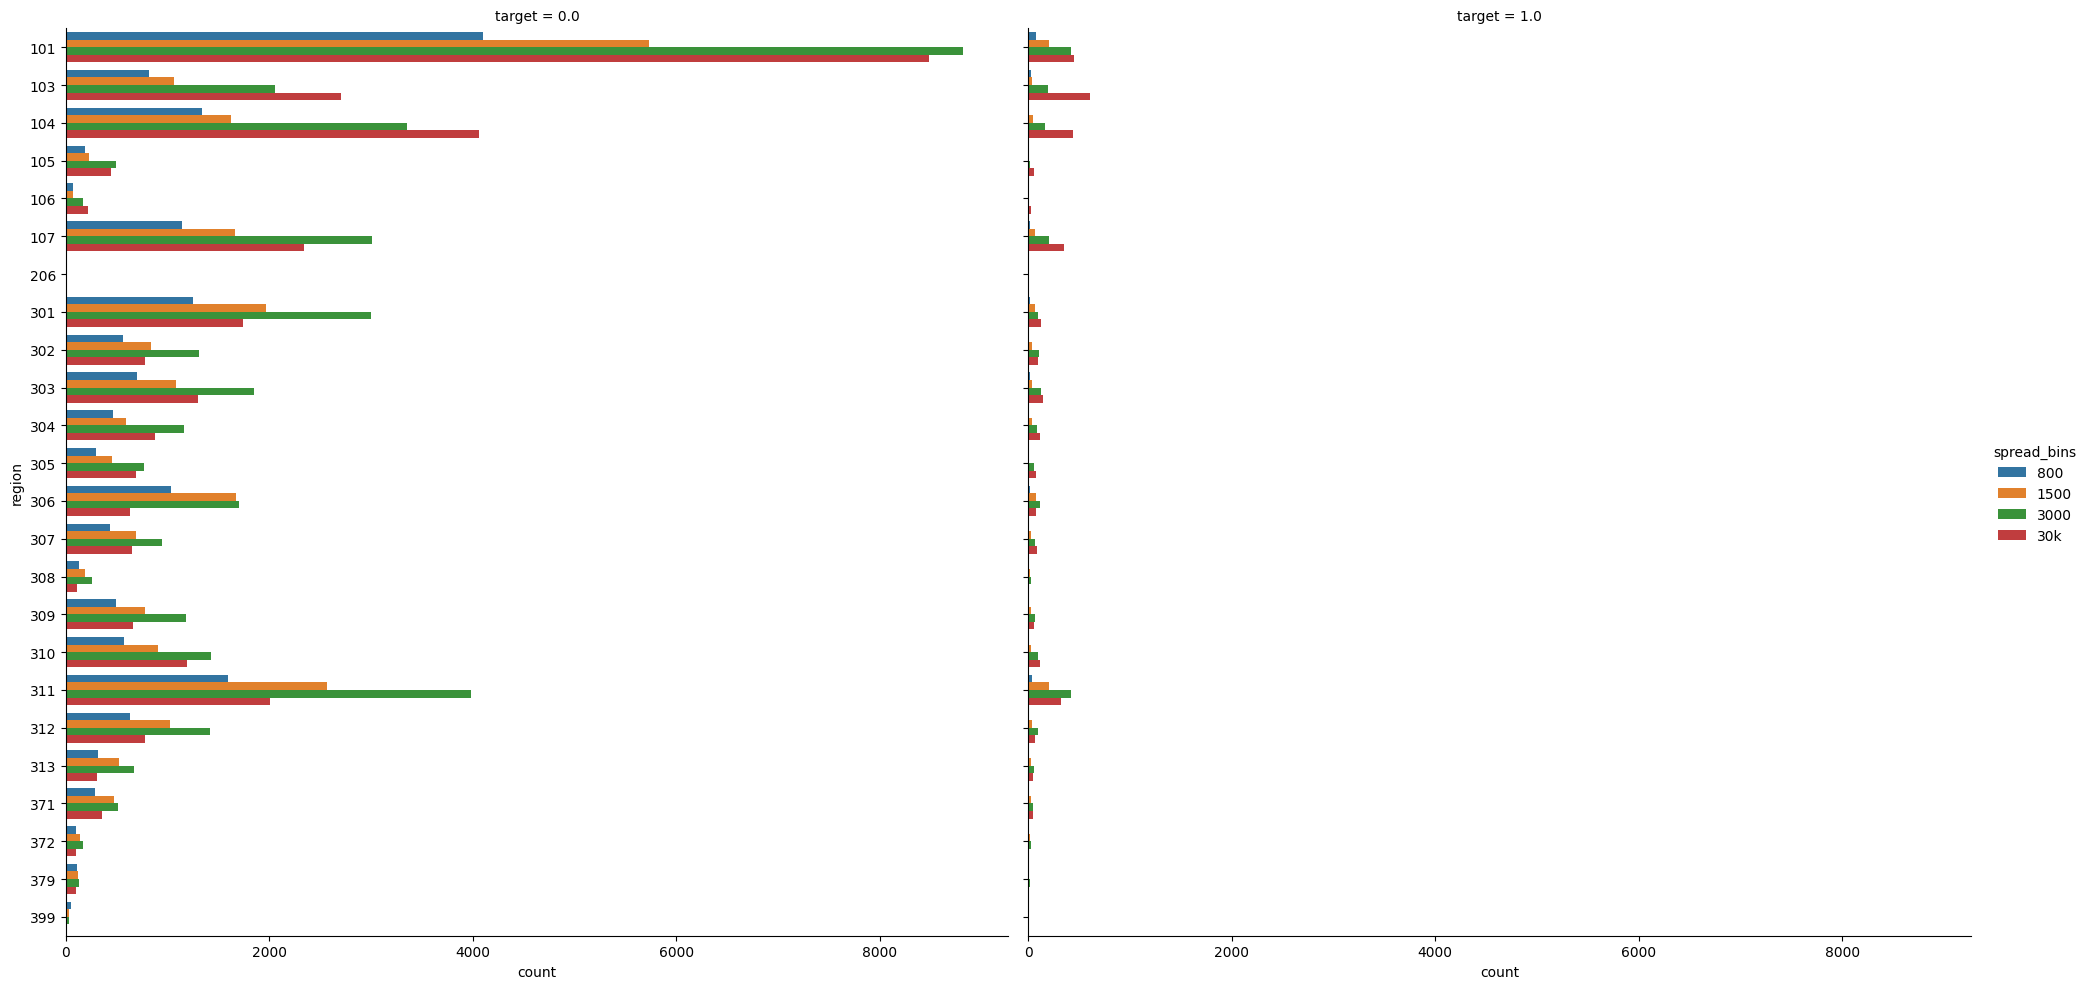

In [ ]:
sns.catplot(df_y_spread, y = 'region', hue= 'spread_bins', kind = 'count', orient = 'h', col = 'target', height= 10, aspect= 1.0)

#### Consumption level Investigation

In [67]:
df= df.drop('counter_coefficient', axis = 1)

,disrict,client_catg,region,target,tarif_type,counter_statue,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,...,old_index,new_index,months_number,counter_type,total_cons,index_cons,day,month,year,start_year
client_id,,,,,,,,,,,,,,,,,,,,,
train_Client_100032,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
train_Client_100037,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
train_Client_100083,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56
train_Client_100091,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43
train_Client_100109,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_Client_99921,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
train_Client_99947,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66
train_Client_99954,28,28,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28


##### Aggregation by client id with sum of consumption lvls

In [68]:
cons_levels = ['consommation_level_1',"consommation_level_2","consommation_level_3", "consommation_level_4"]

In [69]:
s = pd.Series([1, 1, 1, 1, 100])
s.autocorr(lag =1)

nan

### autocorrelation of consumption

In [70]:
def autocor(x):
    return x.autocorr()

In [71]:
df_auto = df.groupby(['client_id'])['total_cons'].apply(lambda x: x.autocorr()).reset_index()

/Users/susanneferschl/neuefische2/fraud_detection_zindi/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/susanneferschl/neuefische2/fraud_detection_zindi/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [72]:
df_auto = pd.merge(df_auto, client[['client_id', 'target','region']], on = 'client_id', how = 'left')

In [73]:
df_auto[df_auto['total_cons'].isna()].groupby('target')['client_id'].count()

target
0.0    11732
1.0       89
Name: client_id, dtype: int64

In [74]:
df_auto.isna().sum()

client_id         0
total_cons    11821
target            0
region            0
dtype: int64

In [75]:
df_auto.describe()

,total_cons,target,region
count,123672.000000,135493.000000,135493.000000
mean,-0.069241,0.055841,206.159809
std,0.317797,0.229614,104.207044
min,-1.000000,0.000000,101.000000
25%,-0.217413,0.000000,103.000000
50%,-0.073106,0.000000,107.000000
75%,0.088432,0.000000,307.000000
max,1.000000,1.000000,399.000000


In [76]:
bins = [-1.1, -0.3, 0, 0.3, 1.1]
labels = ['-0.3', '0', '0.3', '1']
df_auto['autocorr_bins'] = pd.cut(df_auto['total_cons'], bins=bins, labels=labels)

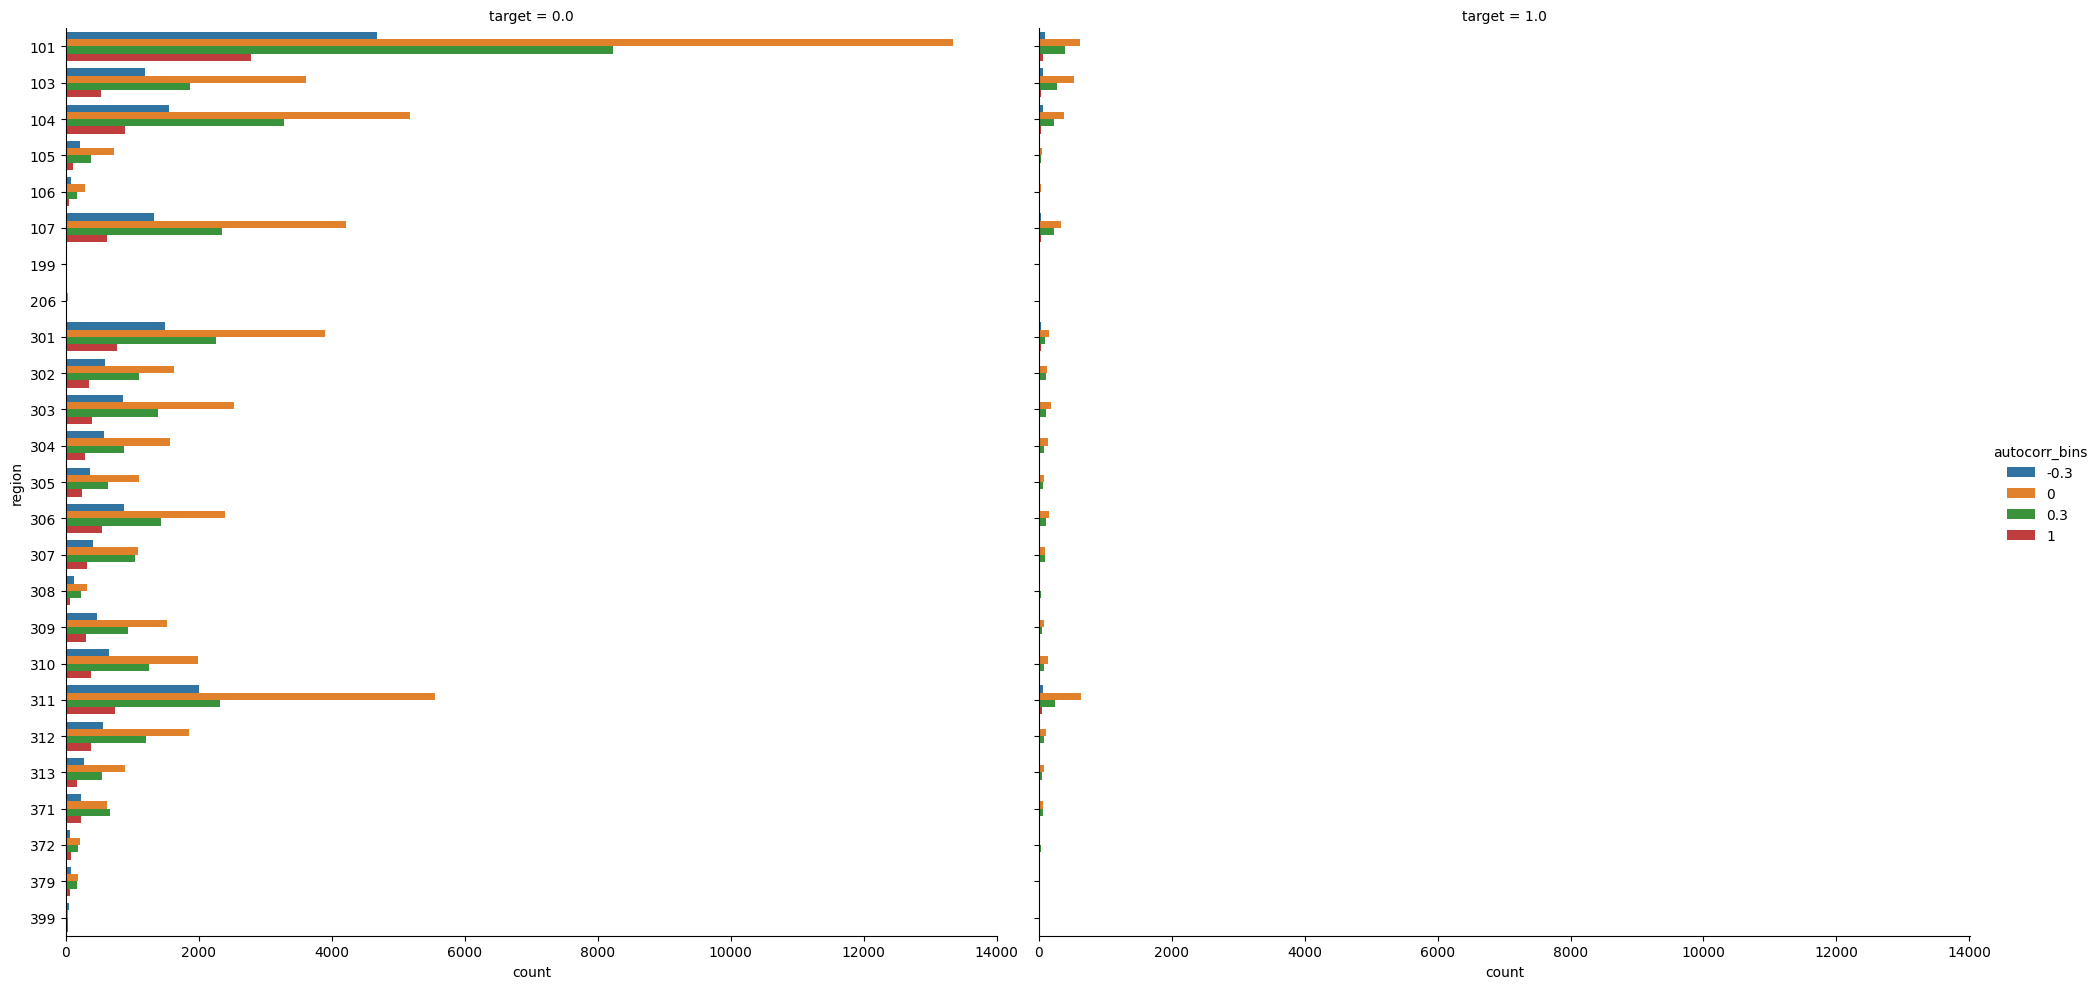

In [ ]:
sns.catplot(df_auto, y = 'region', hue= 'autocorr_bins', kind = 'count', orient = 'h', col = 'target', height= 10, aspect= 1.0)

consumption each year

In [77]:
df_year_cons = df.groupby(['client_id','year'])['total_cons'].sum().reset_index()

In [ ]:
df_year_cons

,client_id,year,total_cons
0,train_Client_0,2005,124
1,train_Client_0,2006,462
2,train_Client_0,2007,698
3,train_Client_0,2008,622
4,train_Client_0,2009,894
...,...,...,...
1221222,train_Client_99997,2017,1208
1221223,train_Client_99997,2018,902
1221224,train_Client_99997,2019,1653
1221225,train_Client_99998,2005,741


In [78]:
ts = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# calculate the autocorrelation
autocorr = ts.autocorr(lag =2)

print(autocorr)

1.0


In [79]:
import statsmodels.api as sm

# create a sample time series
ts = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# plot the ACF
sm.graphics.plot_acf(ts, lags=10)

AttributeError: module 'statsmodels.graphics.api' has no attribute 'plot_acf'

<Axes: xlabel='total_cons', ylabel='year'>

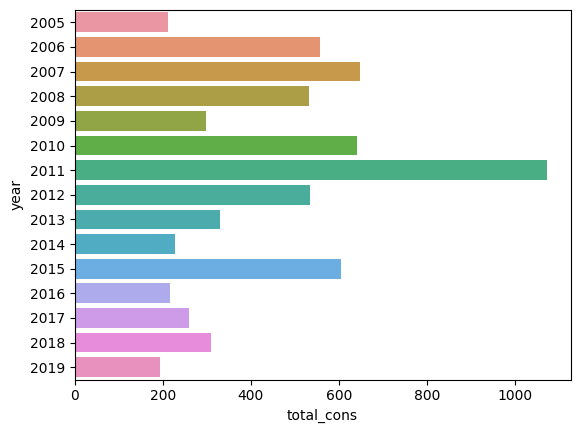

In [80]:
sns.barplot(df_year_cons[df_year_cons['client_id']== "train_Client_50"], y = 'year', x = 'total_cons', orient = 'h')

In [81]:
df.groupby(['year'])[cons_levels].describe().reset_index()

year consommation_level_1                                                 
                        count         mean          std  min     25%    50%   
0   1977                 10.0   106.200000    98.741863  0.0   23.00   89.5  \
1   1978                 56.0    83.428571   139.253445  0.0    0.75   49.5   
2   1979                129.0   623.480620  1871.697279  0.0   20.00   81.0   
3   1980                158.0   218.265823   442.569170  0.0   33.25   68.0   
4   1981                205.0   246.595122   865.946788  0.0   14.00   63.0   
5   1982                197.0   280.253807   725.785469  0.0   11.00   66.0   
6   1983                157.0   237.050955   572.144670  0.0   23.00   91.0   
7   1984                812.0   157.866995   236.950342  0.0   49.00  106.0   
8   1985                471.0   213.596603   552.525030  0.0   32.00   97.0   
9   1986                422.0   210.075829   454.120861  0.0   13.00   95.0   
10  1987                328.0   398.112805  1132.083010  0.0    2.00  135.0   
11  1988                373.0   318.466488   997.479297  0.0   14.00  147.0   
12  1989                438.0   386.785388  1048.111982  0.0   75.25  200.0   
13  1990                472.0   429.845339   825.977195  0.0   65.75  200.0   
14  1991                533.0   497.045028  1943.731672  0.0   75.00  200.0   
15  1992                591.0   554.219966  3110.067582  0.0   67.50  200.0   
16  1993                547.0   448.380256  1045.905025  0.0   72.50  200.0   
17  1994                638.0   439.103448   910.226278  0.0   61.50  200.5   
18  1995                922.0   413.255965   878.912856  0.0    9.25  200.0   
19  1996               1198.0   527.905676  1383.465245  0.0   41.00  200.0   
20  1997               1409.0   498.502484  1761.355841  0.0   22.00  200.0   
21  1998               1273.0   509.283582  1394.417344  0.0   20.00  200.0   
22  1999               1476.0   579.562331  1345.654849  0.0   44.75  200.0   
23  2000               1579.0   627.569348  1885.423657  0.0   47.00  219.0   
24  2001               1718.0   656.684517  1815.787158  0.0   48.00  220.0   
25  2002               1949.0  1050.670087  5083.459166  0.0   24.00  204.0   
26  2003               1892.0   810.332981  2936.867991  0.0    3.00  200.0   
27  2004               2159.0   686.912923  2144.520100  0.0    1.00  200.0   
28  2005              64663.0   402.900855   611.575772  0.0   88.00  254.0   
29  2006             221771.0   421.997682   540.093600  0.0  100.00  293.0   
30  2007             246189.0   410.114258   590.978885  0.0   94.00  282.0   
31  2008             263216.0   411.744886   605.754376  0.0   90.00  280.0   
32  2009             284375.0   414.623887   585.610065  0.0   88.00  277.0   
33  2010             316229.0   400.293142   586.926254  0.0   79.00  258.0   
34  2011             310402.0   434.233713   609.196268  0.0   80.00  276.0   
35  2012             322116.0   443.132586  1860.549663  0.0   82.00  278.0   
36  2013             335944.0   437.727672   598.722962  0.0   80.00  271.0   
37  2014             343374.0   400.190815   546.402403  0.0   77.00  283.0   
38  2015             360759.0   405.336468   555.288173  0.0   74.00  287.0   
39  2016             383654.0   384.467783   539.453645  0.0   70.00  267.0   
40  2017             410932.0   373.389279   499.652596  0.0   68.00  257.0   
41  2018             335650.0   379.496041   556.566115  0.0   75.00  265.0   
42  2019             255363.0   458.608573   596.319852  0.0   88.00  296.0   

                     consommation_level_2  ... consommation_level_3            
       75%       max                count  ...                  75%      max   
0   159.25     279.0                 10.0  ...                  0.0      0.0  \
1    90.00     932.0                 56.0  ...                  0.0      0.0   
2   310.00   12643.0                129.0  ...                  0.0      0.0   
3   173.00    2645.0                158.0  ...  

In [82]:
df_lvl_sum = df.groupby('client_id')[cons_levels].sum().reset_index()

In [83]:
df_lvl_sum.describe()

,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4
count,1.354930e+05,1.354930e+05,135493.000000,1.354930e+05
mean,1.357895e+04,3.612063e+03,670.926011,1.748695e+03
std,1.730569e+04,2.297694e+04,2959.859852,1.825613e+04
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,3.048000e+03,0.000000e+00,0.000000,0.000000e+00
50%,1.031200e+04,1.710000e+02,0.000000,0.000000e+00
75%,1.974500e+04,1.763000e+03,152.000000,0.000000e+00
max,1.290954e+06,2.245578e+06,463655.000000,2.850472e+06


#### Effect of district on the target

In [84]:
df_dis = df.groupby('client_id')['disrict'].count().reset_index()
df_dis = pd.merge(df_dis, client[['client_id', "target", 'disrict']], on = 'client_id', how = 'left')

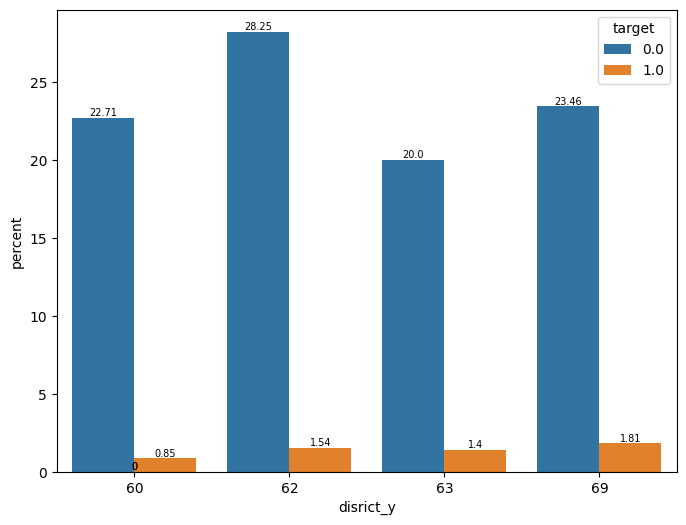

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(df_dis, x= 'disrict_y', hue= 'target',stat= 'percent', orient = 'v')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), str(round(p.get_height(),2)), 
            ha="center", va="bottom", size=7)
    
plt.show()

#### Effect of client_catg on fraud

In [85]:
df_cat = df.groupby(['client_id', 'client_catg'])['disrict'].count().reset_index()
df_cat = pd.merge(df_cat, client[['client_id', "target"]], on = 'client_id', how = 'left')

In [ ]:
df_cat.groupby(['client_catg', 'target']).count()

client_id  disrict
client_catg target                    
11          0.0        124303   124303
            1.0          7191     7191
12          0.0          2229     2229
            1.0            92       92
51          0.0          1395     1395
            1.0           283      283

<Axes: xlabel='client_catg', ylabel='percent'>

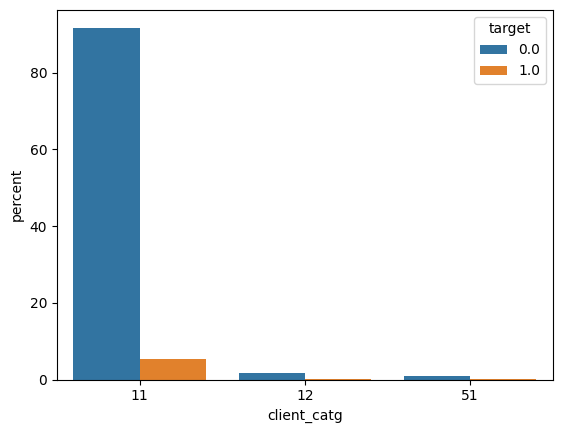

In [ ]:
sns.countplot(df_cat, x= 'client_catg', hue= 'target',stat= 'percent', orient = 'v')

In [ ]:
sns.barplot(df[df['client_id'] == 'train_Client_0'], )

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_statue,reading_remarque,...,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,total_cons,index_cons
0,60,train_Client_0,11,101,1994-12-31,0.0,2014-03-24,11,0,8,...,82,0,0,0,14302,14384,4,ELEC,82,82
1,60,train_Client_0,11,101,1994-12-31,0.0,2013-03-29,11,0,6,...,1200,184,0,0,12294,13678,4,ELEC,1384,1384
2,60,train_Client_0,11,101,1994-12-31,0.0,2015-03-23,11,0,8,...,123,0,0,0,14624,14747,4,ELEC,123,123
3,60,train_Client_0,11,101,1994-12-31,0.0,2015-07-13,11,0,8,...,102,0,0,0,14747,14849,4,ELEC,102,102
4,60,train_Client_0,11,101,1994-12-31,0.0,2016-11-17,11,0,9,...,572,0,0,0,15066,15638,12,ELEC,572,572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,60,train_Client_99998,11,101,1993-12-22,0.0,2005-08-19,10,0,9,...,400,135,0,0,3197,3732,8,ELEC,535,535
4476745,60,train_Client_99998,11,101,1993-12-22,0.0,2005-12-19,10,0,6,...,200,6,0,0,3732,3938,4,ELEC,206,206
4476746,60,train_Client_99999,11,101,1986-02-18,0.0,1996-09-25,11,0,6,...,259,0,0,0,13884,14143,4,ELEC,259,259
4476747,60,train_Client_99999,11,101,1986-02-18,0.0,1996-05-28,11,0,6,...,603,0,0,0,13281,13884,4,ELEC,603,603


#### Possible features

* disrict : YES
* client_id : NO
* client_catg : Maybe
* region : YES
* target : YES
* tarif_type : YES
* counter_statue : NO
* reading_remarque : NO
* consommation_level_1 : Circle around
* consommation_level_2 : Circle around
* consommation_level_3 : Circle around
* consommation_level_4 : Circle around
* old_index : No
* new_index : No
* months_number : NO
* counter_type : YES
* total_cons : No
* index_cons : NO
* day : No
* month : NO
* year : Cirlce around
* start_year : NO
* spread_per_month : YES
* spread_per_year: YES
* Std_per_year : YES
* respective bins

#### Models to be used

* Random Forest Classifier
* Logistic Regression
* XGBoost Classifier
* KNN Classifier
* LGBM Classifier
---

* Dataset balancing : Undersampling, oversampling.
* RSEED = 42
* GridSearchCV
* eval function for evaluation

#### Example Model

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df_std[['yearly_cons_std', "region"]]
y =df_std['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

# smote = SMOTE(random_state=42)
# X_res, y_res = smote.fit_resample(X_train, y_train)

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'max_iter': [500],
    'solver': ['saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 10}, {0: 1, 1: 5}, {0: 1, 1: 2}]
}
recall_scorer = make_scorer(recall_score, pos_label=1)
# Initialize the logistic regression model
logreg = LogisticRegression()

# Initialize GridSearchCV with the logistic regression model and hyperparameter grid
grid_search = GridSearchCV(logreg, param_grid, cv=3, scoring= recall_scorer, n_jobs=-1, verbose=3)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Evaluate the best model on the testing data
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Accuracy on testing data:", accuracy)

ModuleNotFoundError: No module named 'imblearn'

Accuracy : 0.54
Balanced Accuracy : 0.56
F1 Score : 0.13
Recall:  0.59
Precision:  0.08
AUC Score:  0.56


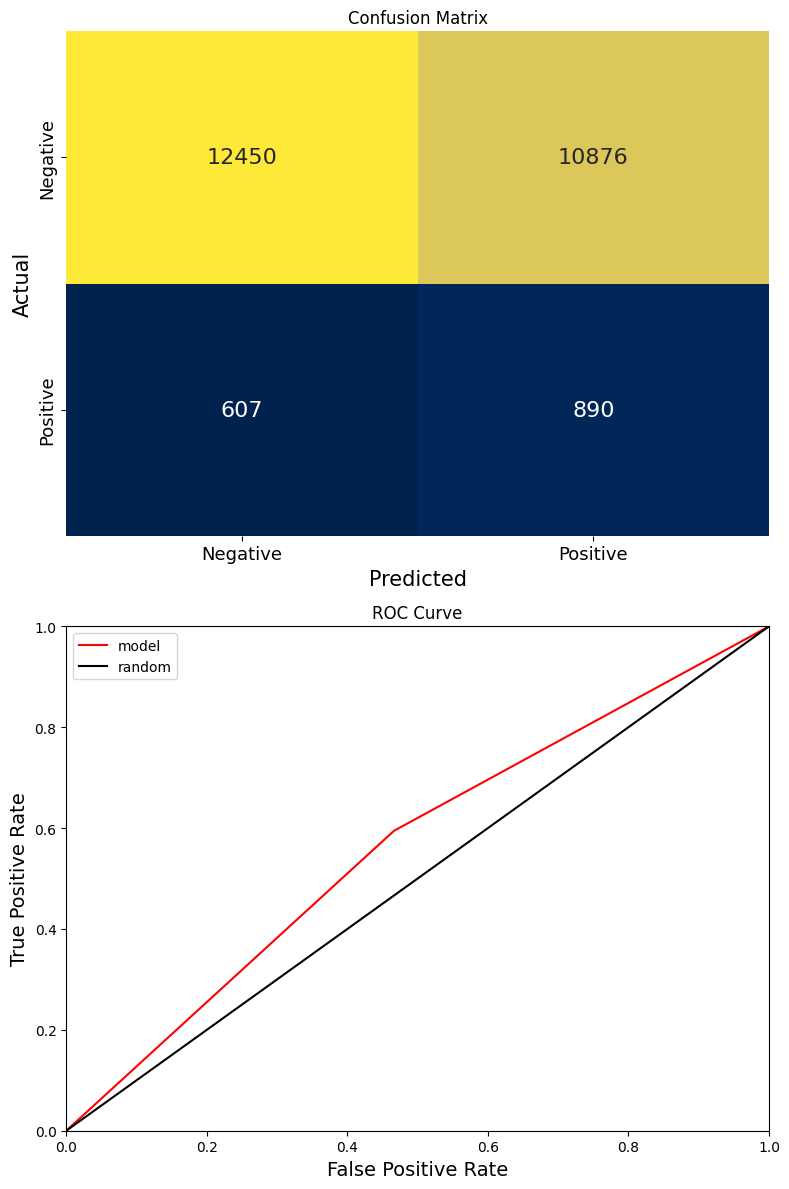

In [ ]:
eval (best_model.predict(X_test), y_test)

##### Dropping columns

In [87]:
cols_to_drop =['counter_statue', 'reading_remarque','old_index', 'new_index','months_number', 'day', 'month', 'start_year' ]
df =df.drop(columns=cols_to_drop,axis =1)

##### Encoding counter types

In [88]:
from sklearn.preprocessing import LabelEncoder
enco = LabelEncoder()
df['counter_type'] = enco.fit_transform(df['counter_type'])

In [89]:
df_int= df.groupby(['client_id', 'year', 'counter_type'])['total_cons'].sum().reset_index()

In [90]:
df_int

,client_id,year,counter_type,total_cons
0,train_Client_0,2005,0,124
1,train_Client_0,2006,0,462
2,train_Client_0,2007,0,698
3,train_Client_0,2008,0,622
4,train_Client_0,2009,0,894
...,...,...,...,...
1774101,train_Client_99997,2017,0,1208
1774102,train_Client_99997,2018,0,902
1774103,train_Client_99997,2019,0,1653
1774104,train_Client_99998,2005,0,741


In [91]:
df_year = df_int.groupby(['client_id', 'counter_type'])['total_cons'].mean().reset_index().dropna()

In [92]:
df_year =pd.merge(df_year, client[['client_id', 'target','region', 'disrict']], on = 'client_id', how = 'left')

In [93]:
df_year

,client_id,counter_type,total_cons,target,region,disrict
0,train_Client_0,0,846.933333,0.0,101,60
1,train_Client_1,0,1375.266667,0.0,107,69
2,train_Client_10,0,1254.750000,0.0,301,62
3,train_Client_100,0,3.000000,0.0,105,69
4,train_Client_1000,0,2583.400000,0.0,303,62
...,...,...,...,...,...,...
196864,train_Client_99996,1,203.714286,0.0,311,63
196865,train_Client_99997,0,1113.750000,0.0,311,63
196866,train_Client_99997,1,184.200000,0.0,311,63
196867,train_Client_99998,0,741.000000,0.0,101,60


In [94]:
df_year = pd.merge(df_year, df[['client_id', 'client_catg', 'tarif_type']], on = 'client_id', how = 'left')

In [95]:
df_year = df_year.groupby(['client_id', 'counter_type']).max().reset_index()

In [96]:
df_year.rename({'total_cons': 'yearly_cons'}, axis=1, inplace=True)

In [97]:
df_year.to_csv('yearly_cons.csv', index=False)